# electricity_market_player

> This module training optimizing and evaluation of RL agent on the electricity market environment.
using PPO with actions mask.

In [ ]:
#| default_exp electricity_market_player

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from abc import ABC
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import optuna
import seaborn as sns
from tqdm import tqdm
from sb3_contrib import MaskablePPO
from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy
from sb3_contrib.common.wrappers import ActionMasker
from sb3_contrib.common.maskable.evaluation import evaluate_policy as maskable_evaluate_policy
from scipy import stats
from stable_baselines3.common.base_class import BaseAlgorithm
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from rliable import metrics, plot_utils, library as rly


from electricity_market.electricity_market_env import ElectricityMarketEnv


In [ ]:
#| export
TOTAL_TIMESTEPS = 10 # 100_000
N_EPISODES = 10
N_TRAILS = 10
N_JOBS = 7
seeds = [123456, 234567] #, 345678, 456789, 567890]
if TOTAL_TIMESTEPS % N_EPISODES != 0:
    raise ValueError("Total_timesteps must be a multiple of n_episodes")
frame_size = TOTAL_TIMESTEPS // N_EPISODES
frames = np.array(list(range(TOTAL_TIMESTEPS // N_EPISODES, TOTAL_TIMESTEPS + 1, frame_size)), dtype=int)

# Decided On granularity of 100 Wh
env_config = {
    "max_timestep": TOTAL_TIMESTEPS,
}
results = {}

In [ ]:
#| export
class Agent(ABC):
    def __init__(self):
        pass

    @classmethod
    def mask_fn(cls, env: ElectricityMarketEnv) -> np.ndarray:
        return env.action_masks()

    @classmethod
    def collect_episodes_rewards(
            cls,
            model: BaseAlgorithm | None,
            env: ElectricityMarketEnv | DummyVecEnv,
            n_episodes: int = N_EPISODES,
            deterministic: bool = True,
            render: bool = False,
            seed: int | None = None
    ) -> list[float]:
        raise NotImplementedError

    @classmethod
    def evaluate_policy(
            cls, hyperparameters: dict | None = None,
            n_episodes: int = N_EPISODES,
            render: bool = False
    ) -> np.array:
        raise NotImplementedError

    @classmethod
    def optimize_agent(cls, trial, n_episodes: int = N_EPISODES):
        raise NotImplementedError



In [ ]:
class MaskableRandomAgent(Agent):
    @classmethod
    def collect_episodes_rewards(
            cls,
            model: BaseAlgorithm,  # Unused for a random agent
            env: ElectricityMarketEnv,
            n_episodes: int = N_EPISODES,
            deterministic: bool = True,
            render: bool = False,
            seed: int | None = None
    ) -> list[float]:
        episode_rewards = []

        for _ in range(n_episodes):
            obs, _ = env.reset(seed=seed)
            done = False
            total_reward = 0.0

            while not done:
                action_mask = env.action_masks()
                valid_actions = np.where(action_mask)[0]  # Get valid actions
                action = np.random.choice(valid_actions)  # Select random valid action

                obs, reward, done, truncated, _ = env.step(action)
                total_reward += reward
                if truncated:
                    break

            episode_rewards.append(total_reward)

        return episode_rewards

    @classmethod
    def evaluate_policy(
            cls,
            hyperparameters: dict | None = None,
            n_episodes: int = N_EPISODES,
            render: bool = False
    ) -> np.array:
        global seeds, frames, env_config

        all_rewards = []

        for seed in tqdm(seeds, desc="seeds"):
            env = ActionMasker(ElectricityMarketEnv(env_config, render_mode="human"), cls.mask_fn)

            seed_rewards = []

            for _ in tqdm(frames, desc="frames"):
                rewards = cls.collect_episodes_rewards(None, env, n_episodes, deterministic=True, render=render, seed=seed)
                seed_rewards.append(rewards)
            seed_rewards = np.array(seed_rewards)
            all_rewards.append(seed_rewards)

        all_rewards = np.array(all_rewards)  # Shape: (num_seeds, num_checkpoints, num_episodes)
        print("\nCollected Rewards (shape: seeds x checkpoints x episodes):\n", all_rewards)

        return all_rewards

    @classmethod
    def optimize_agent(cls, trial, n_episodes: int = N_EPISODES):
        raise NotImplementedError


In [ ]:
#| export
class MaskablePPOAgent(Agent):
    @classmethod
    def collect_episodes_rewards(
            cls,
            model: MaskablePPO,
            env: DummyVecEnv,
            n_episodes: int = N_EPISODES,
            deterministic: bool = True,
            render: bool = False,
            seed: int | None = None
    ) -> list[float]:
        env.seed(seed=seed)
        episode_rewards, _ = maskable_evaluate_policy(
            model, env, deterministic=deterministic, use_masking=True,
            return_episode_rewards=True, n_eval_episodes=n_episodes, render=render
        )
        return episode_rewards

    @classmethod
    def evaluate_policy(
            cls,
            hyperparameters: dict | None = None,
            n_episodes: int = N_EPISODES,
            render: bool = False
    ) -> np.array:
        global seeds, frames, env_config

        if hyperparameters is None:
            hyperparameters = {}
        all_rewards = []

        for seed in tqdm(seeds, desc="seeds"):
            env = DummyVecEnv([
                lambda: Monitor(ActionMasker(ElectricityMarketEnv(env_config, render_mode="human"), cls.mask_fn))
            ])

            model = MaskablePPO(
                MaskableActorCriticPolicy,
                env,
                verbose=0,
                seed=seed,
                **hyperparameters
            )
            seed_rewards = []

            for frame in tqdm(frames, desc="frames", leave=False):
                model.learn(
                    total_timesteps=frame, use_masking=True, reset_num_timesteps=False
                )
                rewards = cls.collect_episodes_rewards(
                    model, env,
                    n_episodes=n_episodes, deterministic=True, render=render, seed=seed
                )
                seed_rewards.append(rewards)

            seed_rewards = np.array(seed_rewards)  # Shape: (num_checkpoints, num_episodes)
            all_rewards.append(seed_rewards)

        all_rewards = np.array(all_rewards)  # Shape: (num_seeds, num_checkpoints, num_episodes)
        print("\nCollected Rewards (shape: seeds x checkpoints x episodes):\n", all_rewards)
        return all_rewards

    @classmethod
    def optimize_agent(cls, trial, n_episodes: int = N_EPISODES):
        global seeds
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
        n_steps = trial.suggest_int('n_steps', 32, 1024, log=True)
        batch_size = trial.suggest_int('batch_size', 16, 256, log=True)
        gamma = trial.suggest_float('gamma', 0.9, 0.9999)
        gae_lambda = trial.suggest_float('gae_lambda', 0.8, 1.0)
        ent_coef = trial.suggest_float('ent_coef', 0.0, 0.02)
        vf_coef = trial.suggest_float('vf_coef', 0.1, 1.0)
        clip_range = trial.suggest_float('clip_range', 0.1, 0.3)
        max_grad_norm = trial.suggest_float('max_grad_norm', 0.1, 1.0)

        trial_seed_rewards = []

        for seed in tqdm(seeds, desc="seeds"):
            env = DummyVecEnv([
                lambda: Monitor(ActionMasker(ElectricityMarketEnv(env_config, render_mode="human"), maskable_ppo_agent.mask_fn))
            ])

            model = MaskablePPO(
                MaskableActorCriticPolicy,
                env,
                learning_rate=learning_rate,
                n_steps=n_steps,
                batch_size=batch_size,
                gamma=gamma,
                gae_lambda=gae_lambda,
                ent_coef=ent_coef,
                vf_coef=vf_coef,
                clip_range=clip_range,
                max_grad_norm=max_grad_norm,
                verbose=0,
                seed=seed
            )

            model.learn(total_timesteps=TOTAL_TIMESTEPS, use_masking=True)
            episode_rewards = cls.collect_episodes_rewards(
                model, env, n_episodes=n_episodes, deterministic=True, render=False, seed=seed
            )

            seed_avg_reward = np.mean(episode_rewards)
            trial_seed_rewards.append(seed_avg_reward)
        aggregated_performance = stats.trim_mean(trial_seed_rewards, proportiontocut=0.25)

        return aggregated_performance


In [ ]:
#| export
# Function to compute aggregated metrics for each algorithm
def aggregate_func(x):
    return np.array([
        metrics.aggregate_median(x),
        metrics.aggregate_iqm(x),
        metrics.aggregate_mean(x)
    ], dtype=np.float64)

# Aggregate results across seeds and episodes for each algorithm
def aggregate_over_checkpoints(evaluation_results):
    aggregated_results = {}
    for algorithm, results in evaluation_results.items():
        # results.shape is (num_seeds, num_checkpoints, num_episodes)
        # We aggregate across seeds and episodes for each checkpoint
        agg_results = np.array([aggregate_func(results[:, i, :]) for i in range(results.shape[1])])
        aggregated_results[algorithm] = agg_results
    return aggregated_results

# Function to plot aggregate metrics (Median, IQM, Mean)
def plot_aggregate_metrics(aggregated_results, algorithms):
    aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
        aggregated_results, aggregate_func, reps=50000
    )

    metric_names = ['Median', 'IQM', 'Mean']
    fig, axes = plot_utils.plot_interval_estimates(
        aggregate_scores,
        aggregate_score_cis,
        metric_names=metric_names,
        algorithms=algorithms,
        xlabel='Reward'
    )
    fig.set_size_inches(10, 5)
    plt.suptitle("Aggregate Metrics with 95% Stratified Bootstrap CIs", y=1.05, fontsize=16)
    plt.xticks(rotation=45, fontsize=12)
    plt.show()

# Function to plot the probability of improvement between two algorithms
def plot_probability_of_improvement(evaluation_results, algorithms):
    for alg1, alg2 in combinations(algorithms, 2):
        algorithm_pairs = {f"{alg1},{alg2}": (evaluation_results[alg1], evaluation_results[alg2])}

        average_probabilities, average_prob_cis = rly.get_interval_estimates(
            algorithm_pairs, metrics.probability_of_improvement, reps=2000
        )

        plot_utils.plot_probability_of_improvement(average_probabilities, average_prob_cis)
        plt.title(f"Probability of Improvement: {alg1} vs {alg2}", pad=20)
        plt.show()

# Function to plot the sample efficiency curve
def plot_sample_efficiency_curve(evaluation_results, frames):
    sample_efficiency_dict = {
        alg: results[:, :, :]
        for alg, results in evaluation_results.items() if len(results.shape) == 3
    }

    iqm_func = lambda scores: np.array([metrics.aggregate_iqm(scores[:, :, frame]) for frame in range(scores.shape[2])])

    iqm_scores, iqm_cis = rly.get_interval_estimates(sample_efficiency_dict, iqm_func, reps=50000)

    plot_utils.plot_sample_efficiency_curve(
        frames=frames + 1,  # Adjust frames if necessary
        point_estimates=iqm_scores,
        interval_estimates=iqm_cis,
        algorithms=sample_efficiency_dict.keys(),
        xlabel='Number of Frames',
        ylabel='IQM Reward'
    )
    plt.title("Sample Efficiency Curve")
    plt.show()

# Function to plot performance profiles (linear and non-linear scaling)
def plot_performance_profiles(evaluation_results, algorithms):
    thresholds = np.linspace(0.0, 8.0, 81)
    score_distributions, score_distributions_cis = rly.create_performance_profile(
        evaluation_results, thresholds
    )

    # Plot performance profiles with linear scale
    fig, ax = plt.subplots(ncols=1, figsize=(7, 5))
    plot_utils.plot_performance_profiles(
        score_distributions,
        thresholds,
        performance_profile_cis=score_distributions_cis,
        colors=dict(zip(algorithms, sns.color_palette('colorblind'))),
        xlabel=r'Normalized Score $(\tau)$',
        ax=ax
    )
    plt.title("Performance Profiles (Linear Scale)")
    plt.show()

    # Plot performance profiles with non-linear scaling
    thresholds = np.logspace(-1, 0, num=50)
    fig, ax = plt.subplots(ncols=1, figsize=(7, 5))
    plot_utils.plot_performance_profiles(
        score_distributions,
        thresholds,
        performance_profile_cis=score_distributions_cis,
        use_non_linear_scaling=True,
        colors=dict(zip(algorithms, sns.color_palette('colorblind'))),
        xlabel=r'Normalized Score $(\tau)$',
        ax=ax
    )
    ax.set_ylim([-1, 1])
    plt.title("Performance Profiles (Non-Linear Scaling)")
    plt.tight_layout()
    plt.show()


def plot_learning_curves(evaluation_results, algorithms):
    """Plots learning curves for multiple algorithms."""
    plt.figure(figsize=(12, 8))

    n_episodes = evaluation_results[algorithms[0]].shape[2]
    episodes = np.arange(1, n_episodes + 1)

    for algorithm in algorithms:
        mean_rewards_per_episode = np.mean(evaluation_results[algorithm], axis=(0, 1))
        std_rewards_per_episode = np.std(evaluation_results[algorithm], axis=(0, 1))
        plt.plot(episodes, mean_rewards_per_episode, label=algorithm, marker='o', linestyle='-')
        plt.fill_between(episodes, mean_rewards_per_episode - std_rewards_per_episode,
                         mean_rewards_per_episode + std_rewards_per_episode, alpha=0.2)

    plt.xlabel('Episodes', fontsize=14)
    plt.ylabel('Mean Episode Reward', fontsize=14)
    plt.title('Learning Curves of Multiple Algorithms', fontsize=16, fontweight='bold')

    plt.legend(loc='best', fontsize=12, title="Algorithms")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.tight_layout(pad=2.0)
    plt.show()

# Main function to call all the individual plot functions
def plot_evaluation_results(evaluation_results: dict) -> None:
    global frames
    algorithms = list(evaluation_results.keys())

    # Aggregate the results across seeds and checkpoints
    aggregated_results = aggregate_over_checkpoints(evaluation_results)

    # Plot aggregate metrics
    plot_aggregate_metrics(aggregated_results, algorithms)

    # Plot Probability of Improvement
    plot_probability_of_improvement(evaluation_results, algorithms)

    # Plot Sample Efficiency Curve
    plot_sample_efficiency_curve(evaluation_results, frames)

    # Plot Performance Profiles
    plot_performance_profiles(evaluation_results, algorithms)

    # Plot Learning Curves
    plot_learning_curves(evaluation_results, algorithms)


In [ ]:
#| export
maskable_random_agent = MaskableRandomAgent()
maskable_ppo_agent = MaskablePPOAgent()

### Evaluation MaskableRandom on ElectricityMarketEnv


In [ ]:
#| export
results["MaskableRandomAgent"] = maskable_random_agent.evaluate_policy(hyperparameters=None, n_episodes=N_EPISODES, render=False)

seeds: 100%|██████████| 2/2 [00:00<00:00,  5.13it/s]


Collected Rewards (shape: seeds x checkpoints x episodes):
 [[[ 0.27168886  0.43277237  0.34134922  0.45819713  0.3453153
    0.57389813  0.30908725  0.50615021  0.50347662  0.42963061]
  [ 0.10563816  0.1217224   0.28951194  0.32503454  0.90102595
    0.40599564  0.28876915  0.34419614 -0.02800454  0.43418232]
  [ 0.19926846  0.70740954  1.06557103  0.02649556  0.21264946
    0.24493373  0.73828528  0.68453999  0.20618792  0.16975955]
  [ 0.91661115  1.0302815   0.5292356   0.624203    0.64972752
    0.05243767  0.21713683  0.52981425  0.43092073  0.64458381]
  [ 0.49015863  0.3052906   0.68829102  0.24396304  0.22612154
    0.1895992   0.50026408  0.05721327  0.49472905  0.52855205]
  [ 0.57207033  0.38168162  0.6064209   0.2824303   0.20695073
    0.30642083  0.31688118  0.4077564   0.0290923   0.44049378]
  [ 0.67933092  0.53253277  0.3284771   0.23417436  0.18738604
    0.0749805   0.46369588  0.12030263  0.03165416  0.20406349]
  [ 0.65881306  0.46302202  0.08401021  0.52881858 

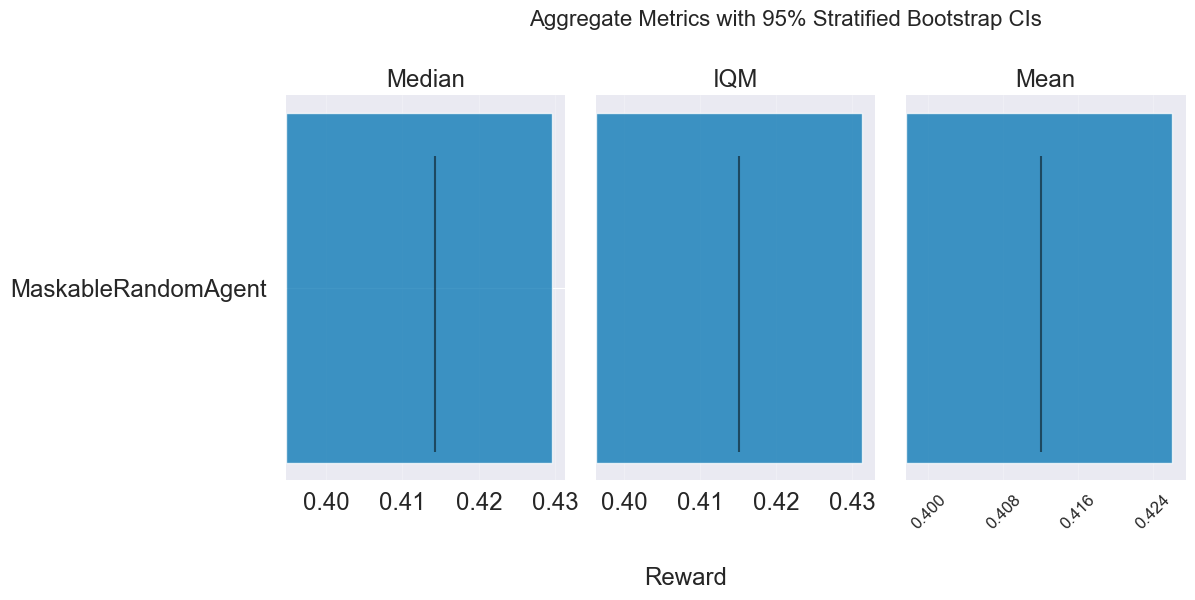

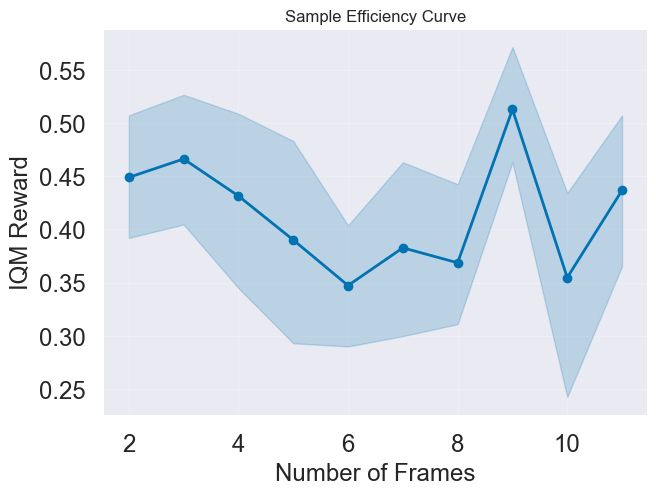

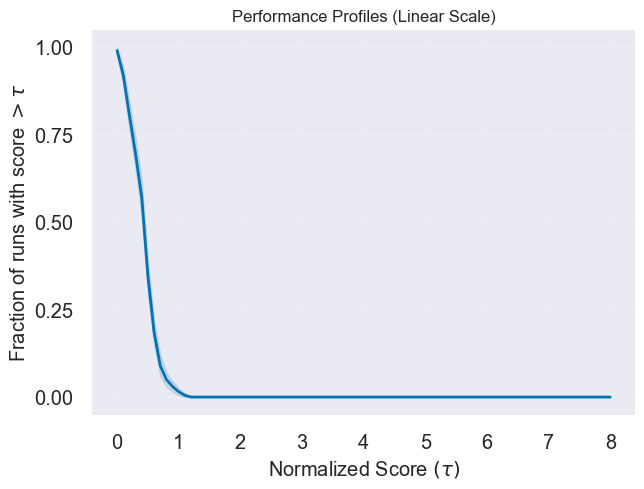

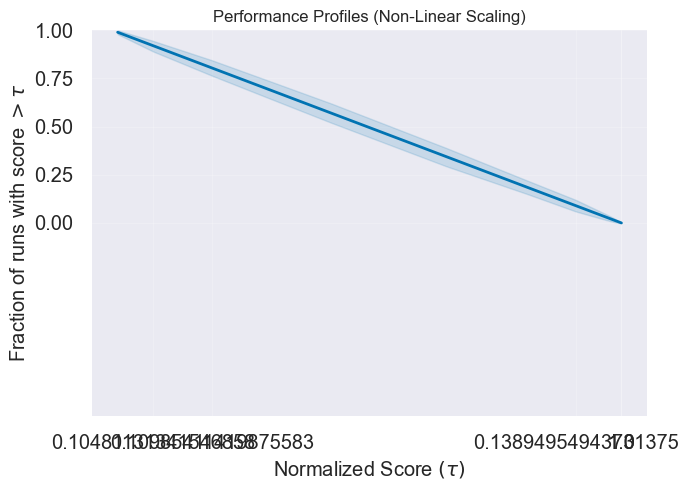

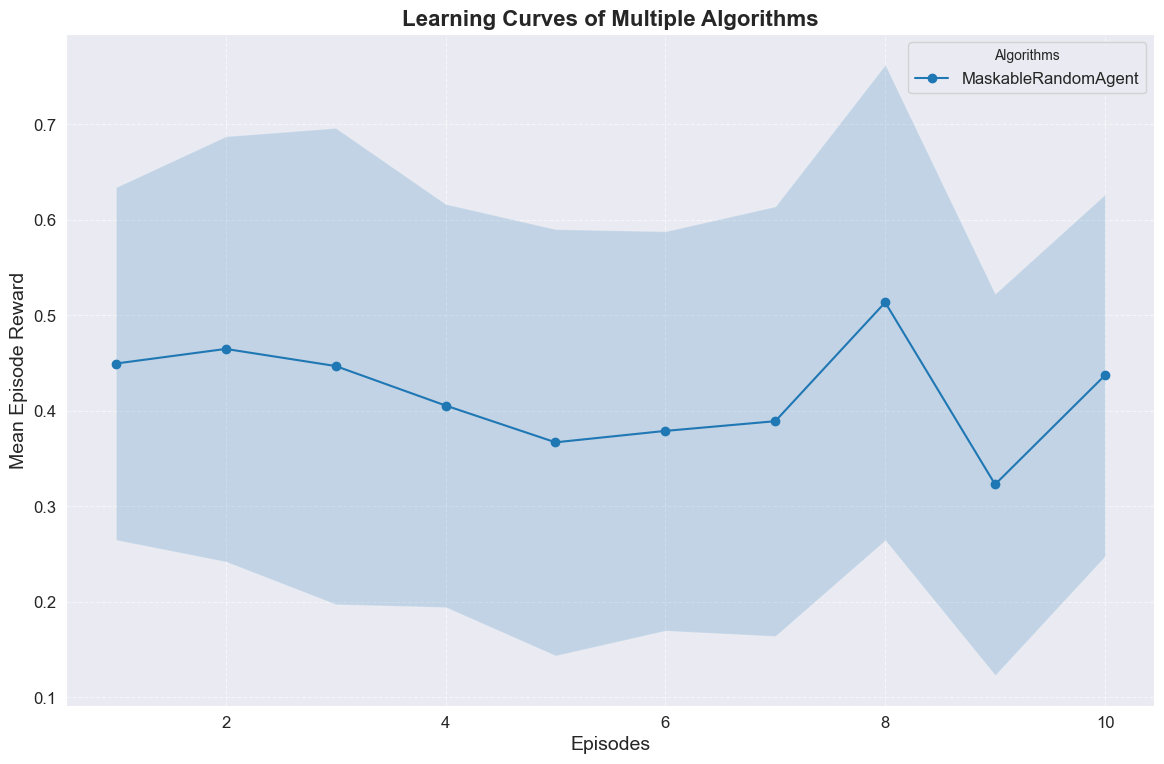

In [ ]:
#| export
plot_evaluation_results(results)

### Evaluation MaskablePPO with default hyperparameters on ElectricityMarketEnv

In [ ]:
#| export
results["MaskablePPOAgent_Baseline"] = maskable_ppo_agent.evaluate_policy(hyperparameters=None, n_episodes=N_EPISODES, render=False)

seeds: 100%|██████████| 2/2 [00:28<00:00, 14.14s/it]   


Collected Rewards (shape: seeds x checkpoints x episodes):
 [[[-2.26368e-01 -1.64551e-01 -2.60638e-01 -6.04870e-02 -2.01571e-01
   -8.97290e-02 -1.67131e-01 -1.29964e-01 -2.24585e-01 -1.42451e-01]
  [-5.19300e-03  1.71830e-01  1.98667e-01  3.93241e-01  2.01146e-01
    3.33040e-02  5.66250e-01  6.98345e-01  2.31061e-01  7.42527e-01]
  [ 1.25628e-01  1.61810e-02 -4.87440e-02 -2.29740e-02 -1.65452e-01
    7.74410e-02 -1.47681e-01 -3.94330e-02 -2.31911e-01 -1.86350e-02]
  [ 1.26485e-01  2.46391e-01  2.89114e-01 -1.15957e-01  1.03200e-03
    3.77856e-01  3.93460e-01  2.86507e-01  1.12932e-01  1.52282e-01]
  [ 2.78902e-01  1.32535e-01  1.16545e-01  7.09460e-02  6.31540e-02
   -4.68530e-02  5.62350e-02  3.42128e-01  8.71470e-02 -1.45830e-02]
  [ 3.36489e-01  3.83027e-01  4.66569e-01  2.47018e-01  3.30468e-01
    3.32851e-01  3.76518e-01  8.19824e-01  4.04822e-01  3.92801e-01]
  [ 1.84290e-01  1.38101e-01  3.30311e-01  5.45392e-01  4.29224e-01
    1.05097e-01  5.66240e-01  4.78900e-03  4.5148

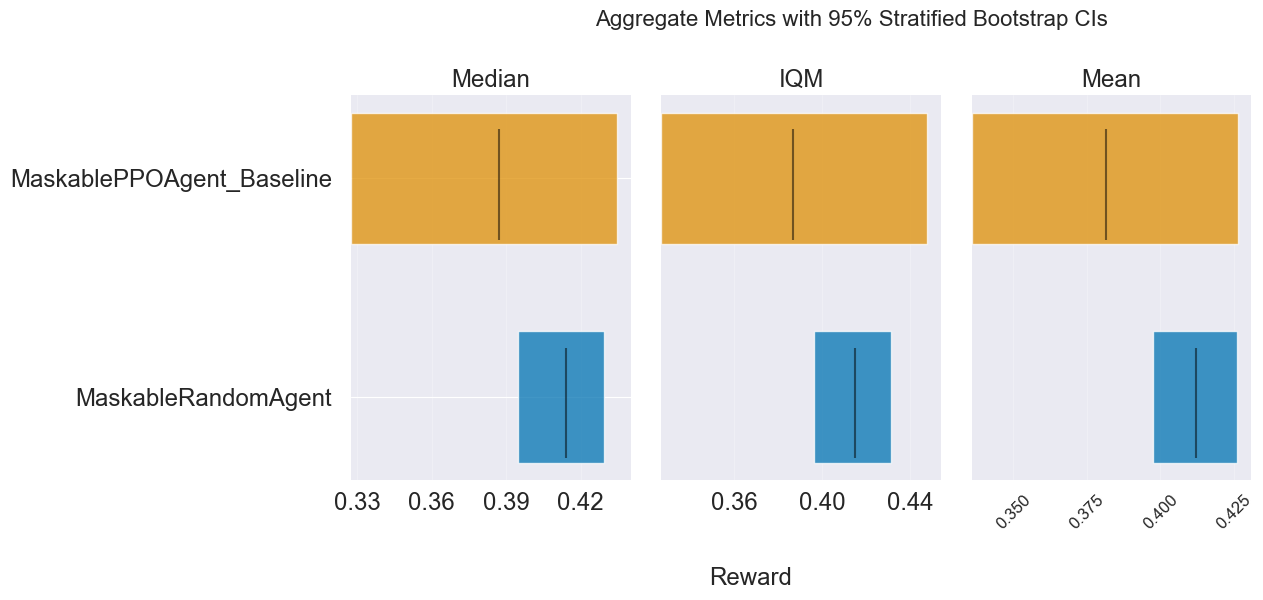

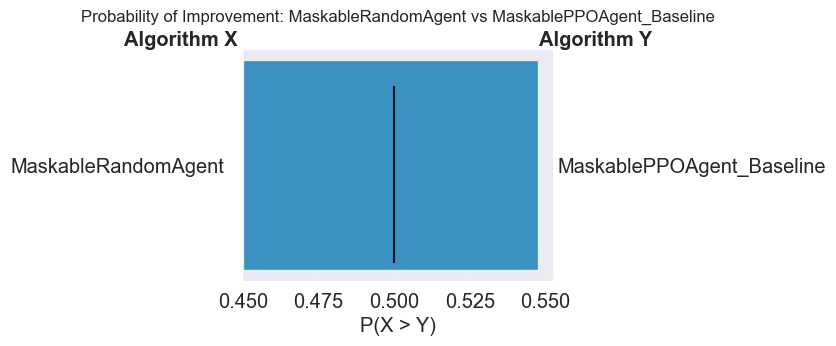

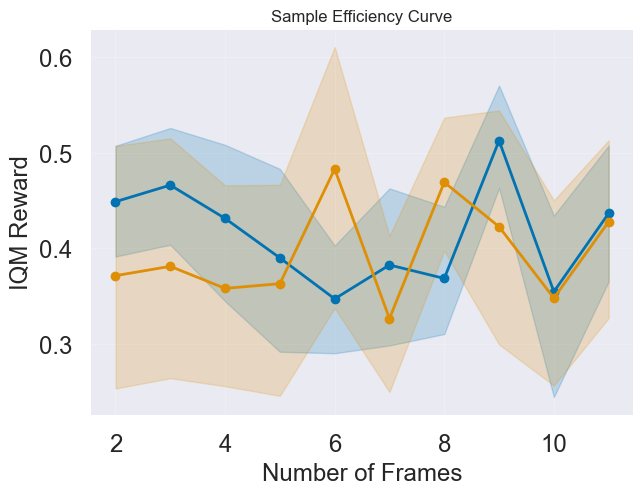

In [ ]:
#| export
plot_evaluation_results(results)

### Hypertuning MaskablePPO with default hyperparameters on ElectricityMarketEnv

In [ ]:
#| export
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(maskable_ppo_agent.optimize_agent, n_trials=N_TRAILS, n_jobs=N_JOBS)

print("Best trial:", study.best_trial)

### Evaluation MaskablePPO with optimized hyperparameters on ElectricityMarketEnv

In [ ]:
#| export
results["MaskablePPOAgent_Optimized"] = maskable_ppo_agent.evaluate_policy(hyperparameters=study.best_trial.params, n_episodes=N_EPISODES, render=False)

In [ ]:
#| export
plot_evaluation_results(results)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()